In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import os
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential,load_model,Model
import itertools

In [7]:
# import random, os
# from PIL import Image
# path = r"C:\Users\nabr9\OneDrive\Documents\диплом\data\data\train\Apple___Apple_scab"
# for i in range(4):
#     files = os.listdir(path)
#     random_filename = random.choice(files)
#     file = path+'\\'+random_filename
#     Image.open(file).show()

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
batch_size = 100
img_height = 200
img_width = 200

In [4]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\nabr9\OneDrive\Documents\диплом\data\data\train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 77873 files belonging to 43 classes.


In [5]:
validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\nabr9\OneDrive\Documents\диплом\data\data\valid',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 20101 files belonging to 43 classes.


In [6]:
rescale = Rescaling(scale=1.0/255)
training_ds = training_ds.map(lambda image,label:(rescale(image),label))
validation_ds  = validation_ds.map(lambda image,label:(rescale(image),label))

In [7]:
data_dir = r"C:\Users\nabr9\OneDrive\Documents\диплом\data\data"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [8]:
# Number of images for each disease
nums_train = {}
nums_val = {}
for disease in diseases:
    nums_train[disease] = len(os.listdir(train_dir + '/' + disease))
    nums_val[disease] = len(os.listdir(valid_dir + '/' + disease))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


,no. of images
Anthracnose 230,1723
Apple___Apple_scab,2016
Apple___Black_rot,1987
Apple___Cedar_apple_rust,1760
Apple___healthy,2008
Blueberry___healthy,1816
Cherry_(including_sour)___healthy,1826
Cherry_(including_sour)___Powdery_mildew,1683
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,1642
Corn_(maize)___Common_rust_,1907


<Axes: title={'center': 'Train data distribution '}, xlabel='Number of image', ylabel='Planet'>

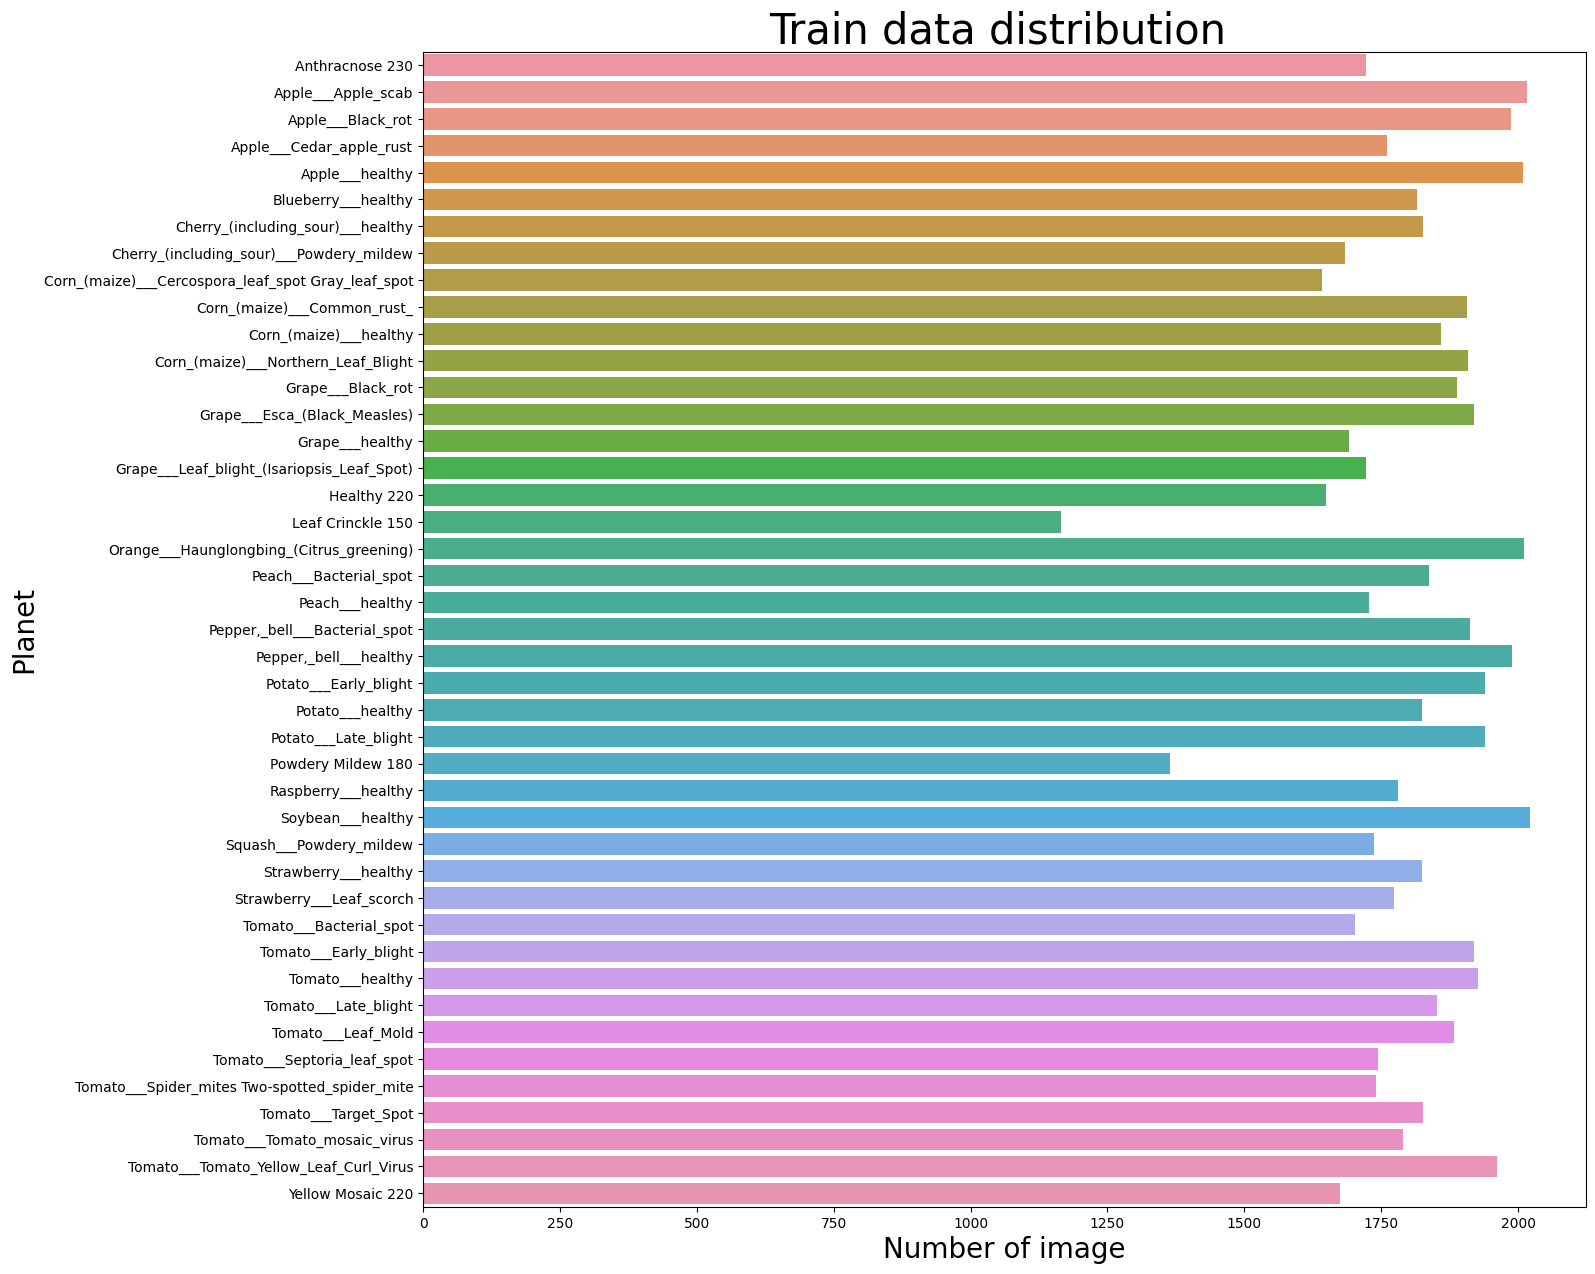

In [11]:
plt.figure(figsize=(15,15))
plt.title('Train data distribution ',fontsize=30)
plt.xlabel('Number of image',fontsize=20)
plt.ylabel('Planet',fontsize=20)

keys = list(nums_train.keys())
# get values in the same order as keys, and parse percentage values
vals = list(nums_train.values())
sns.barplot(y=keys, x=vals)

In [12]:
img_per_class_val = pd.DataFrame(nums_val.values(), index=nums_val.keys(), columns=["no. of images"])
print('Validation data distribution :')
img_per_class_val

Validation data distribution :


,no. of images
Anthracnose 230,575
Apple___Apple_scab,504
Apple___Black_rot,497
Apple___Cedar_apple_rust,440
Apple___healthy,502
Blueberry___healthy,454
Cherry_(including_sour)___healthy,456
Cherry_(including_sour)___Powdery_mildew,421
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,410
Corn_(maize)___Common_rust_,477


<Axes: title={'center': 'Validation data distribution '}, xlabel='Number of image', ylabel='Planet'>

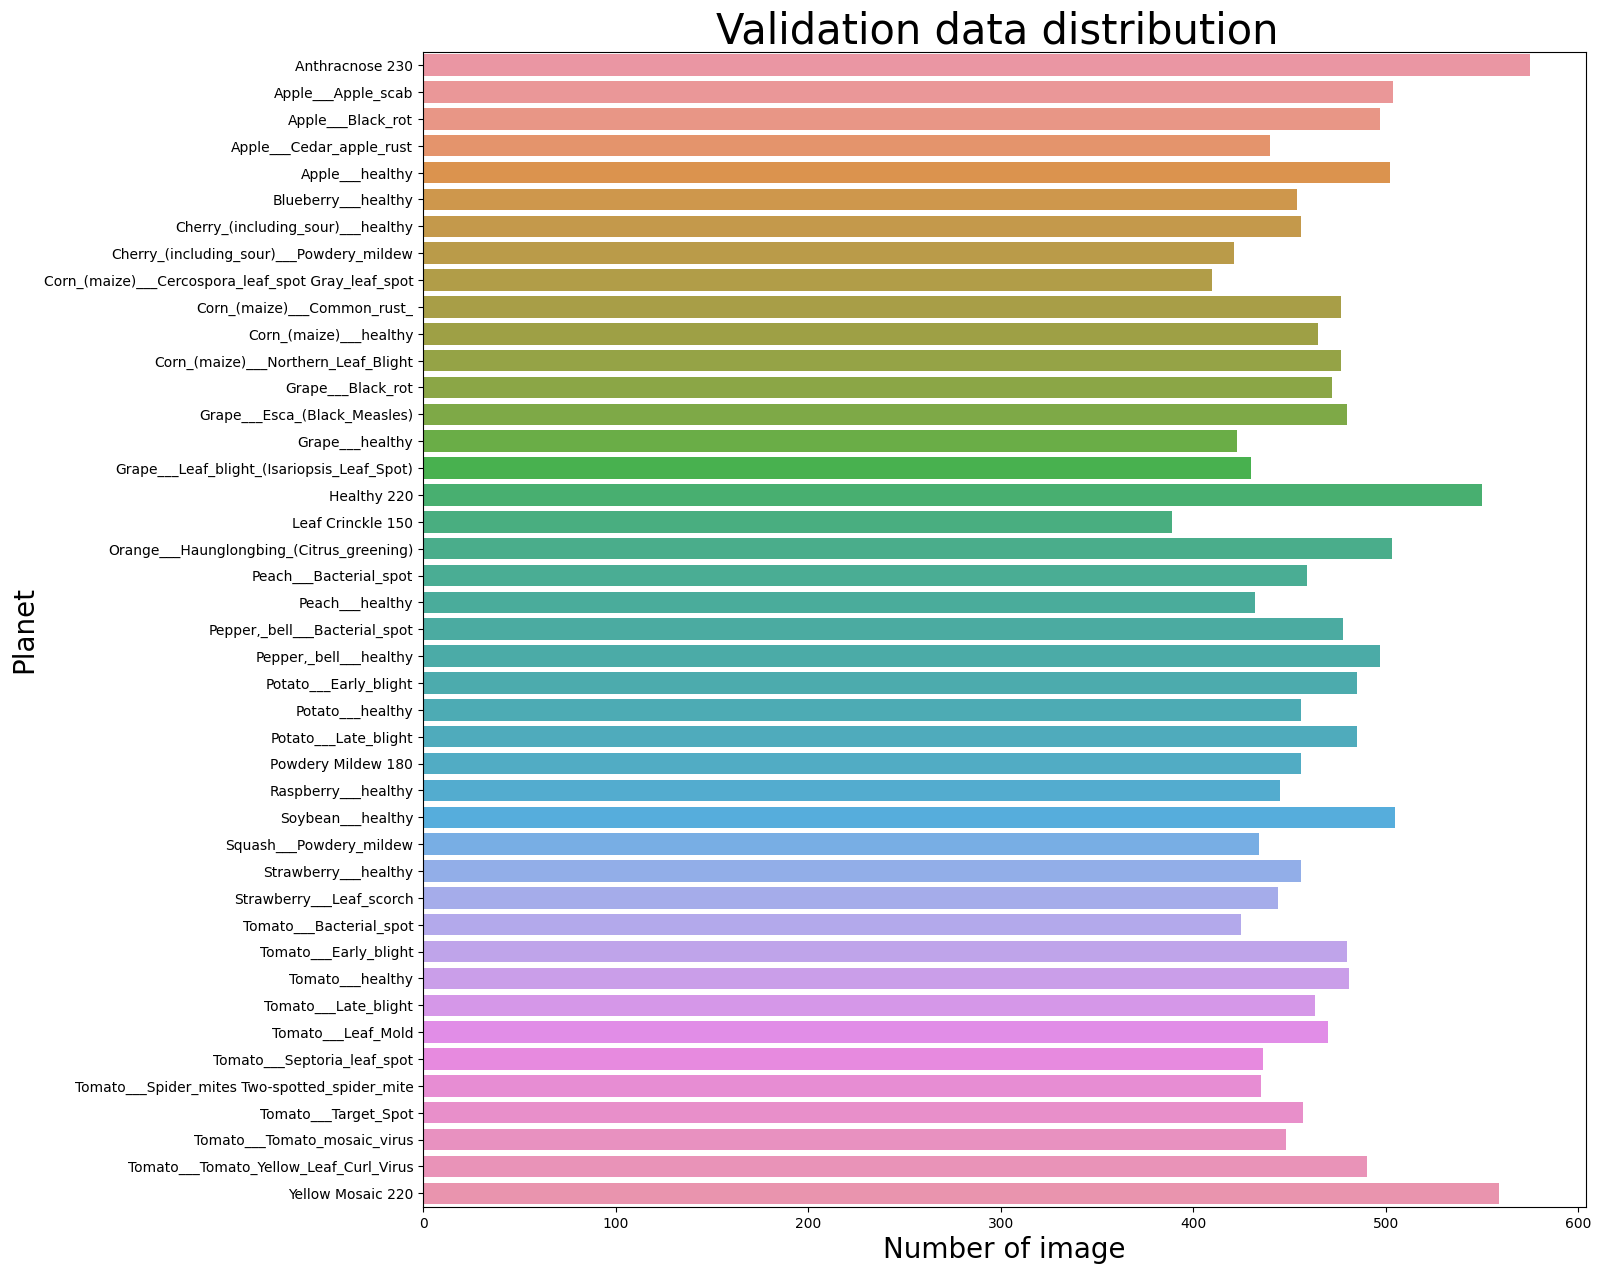

In [13]:
plt.figure(figsize=(15,15))
plt.title('Validation data distribution ',fontsize=30)
plt.xlabel('Number of image',fontsize=20)
plt.ylabel('Planet',fontsize=20)

keys = list(nums_val.keys())
# get values in the same order as keys, and parse percentage values
vals = list(nums_val.values())
sns.barplot(y=keys, x=vals)

In [14]:
model = tf.keras.models.Sequential()

model.add(layers.Conv2D(32,(3,3),activation="relu",padding="same",input_shape=(200,200,3)))
model.add(layers.Conv2D(32,(3,3),activation="relu",padding="same"))
model.add(layers.MaxPooling2D(3,3))

model.add(layers.Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(layers.Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(layers.MaxPooling2D(3,3))

model.add(layers.Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(layers.Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(layers.MaxPooling2D(3,3))

model.add(layers.Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(layers.Conv2D(256,(3,3),activation="relu",padding="same"))

model.add(layers.Conv2D(512,(5,5),activation="relu",padding="same"))
model.add(layers.Conv2D(512,(5,5),activation="relu",padding="same"))

model.add(layers.Flatten())

model.add(layers.Dense(1568,activation="relu"))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(43,activation="softmax"))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 66, 66, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 66, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 66, 66, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 128)       7

In [14]:
# MyCnn = tf.keras.models.Sequential([
#   layers.BatchNormalization(),
#   layers.Conv2D(32, 3,input_shape=(200, 200, 3), activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.25),
#   layers.Conv2D(64, 3, activation='relu'),
#   layers.BatchNormalization(),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.25),
#   layers.Conv2D(128, 3, activation='relu'),
#   layers.BatchNormalization(),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.25),
#   layers.Flatten(),
#   layers.Dense(256, activation='relu'),
#   layers.BatchNormalization(),
#   layers.Dense(len(class_names), activation= 'softmax')
# ])

In [15]:
ep = 10
history = model.fit_generator(training_ds,
          validation_data=validation_ds,
          epochs = ep)

C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
779/779 [==============================] - 134s 152ms/step - loss: 2.1793 - accuracy: 0.3754 - val_loss: 0.9445 - val_accuracy: 0.7115
Epoch 2/10
779/779 [==============================] - 112s 144ms/step - loss: 0.7823 - accuracy: 0.7499 - val_loss: 0.5365 - val_accuracy: 0.8250
Epoch 3/10
779/779 [==============================] - 113s 145ms/step - loss: 0.4874 - accuracy: 0.8401 - val_loss: 0.3502 - val_accuracy: 0.8809
Epoch 4/10
779/779 [==============================] - 113s 144ms/step - loss: 0.3511 - accuracy: 0.8832 - val_loss: 0.2927 - val_accuracy: 0.9011
Epoch 5/10
779/779 [==============================] - 113s 144ms/step - loss: 0.2698 - accuracy: 0.9097 - val_loss: 0.2900 - val_accuracy: 0.9028
Epoch 6/10
779/779 [==============================] - 113s 145ms/step - loss: 0.2099 - accuracy: 0.9282 - val_loss: 0.2320 - val_accuracy: 0.9225
Epoch 7/10
779/779 [==============================] - 113s 144ms/step - loss: 0.1720 - accuracy: 0.9413 - val_loss: 0.1916 -

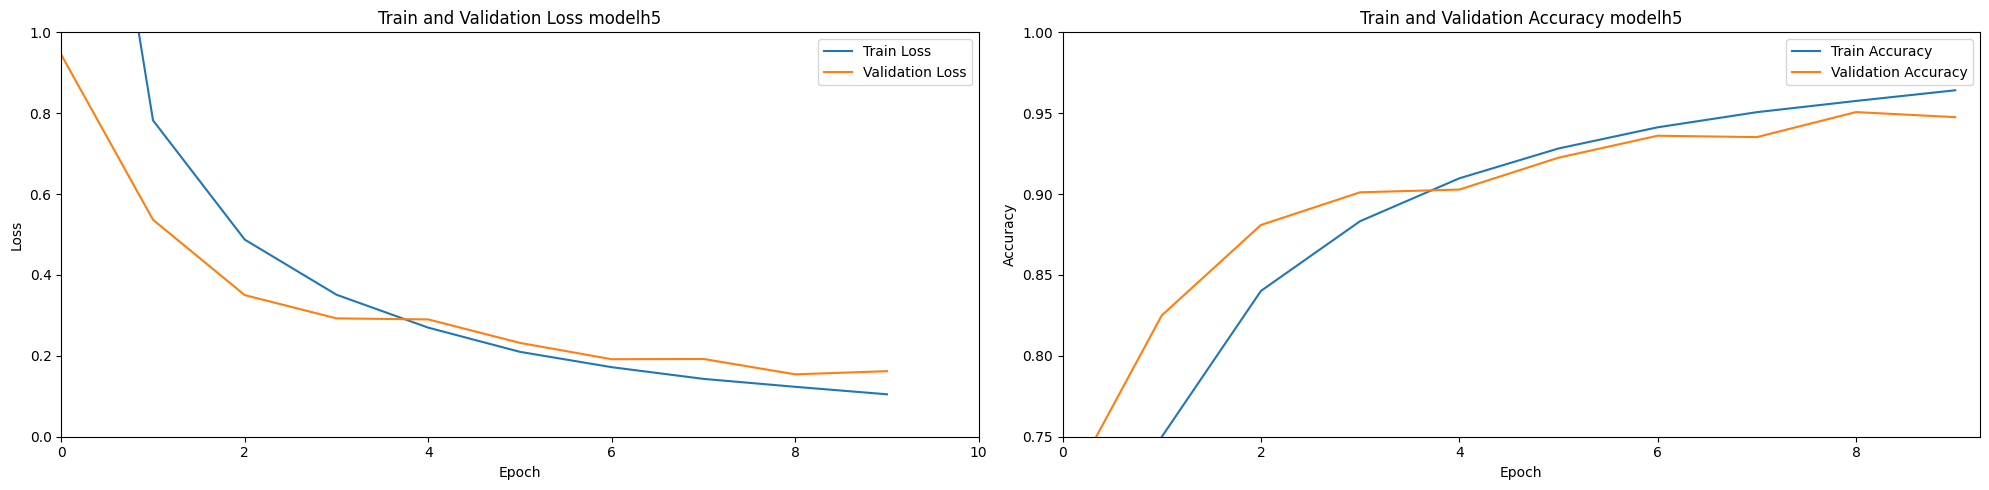

In [17]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss modelh5")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy modelh5")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [17]:
# AccuracyVector = []
# plt.figure(figsize=(30, 30))
# for images, labels in validation_ds.take(1):
#     predictions = MyCnn.predict(images)
#     predlabel = []
#     prdlbl = []
    
#     for mem in predictions:
#         predlabel.append(class_names[np.argmax(mem)])
#         prdlbl.append(np.argmax(mem))
    
#     AccuracyVector = np.array(prdlbl) == labels
#     for i in range(40):
#         ax = plt.subplot(10, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
#         plt.axis('off')
#         plt.grid(True)

In [18]:
labels = []
predictions = []
for x,y in validation_ds:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

In [19]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [20]:
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Validation Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Train Accuracy  : 96.70 %
Test Accuracy   : 94.98 %
Precision Score : 94.98 %
Recall Score    : 94.98 %


<Figure size 2000x500 with 0 Axes>

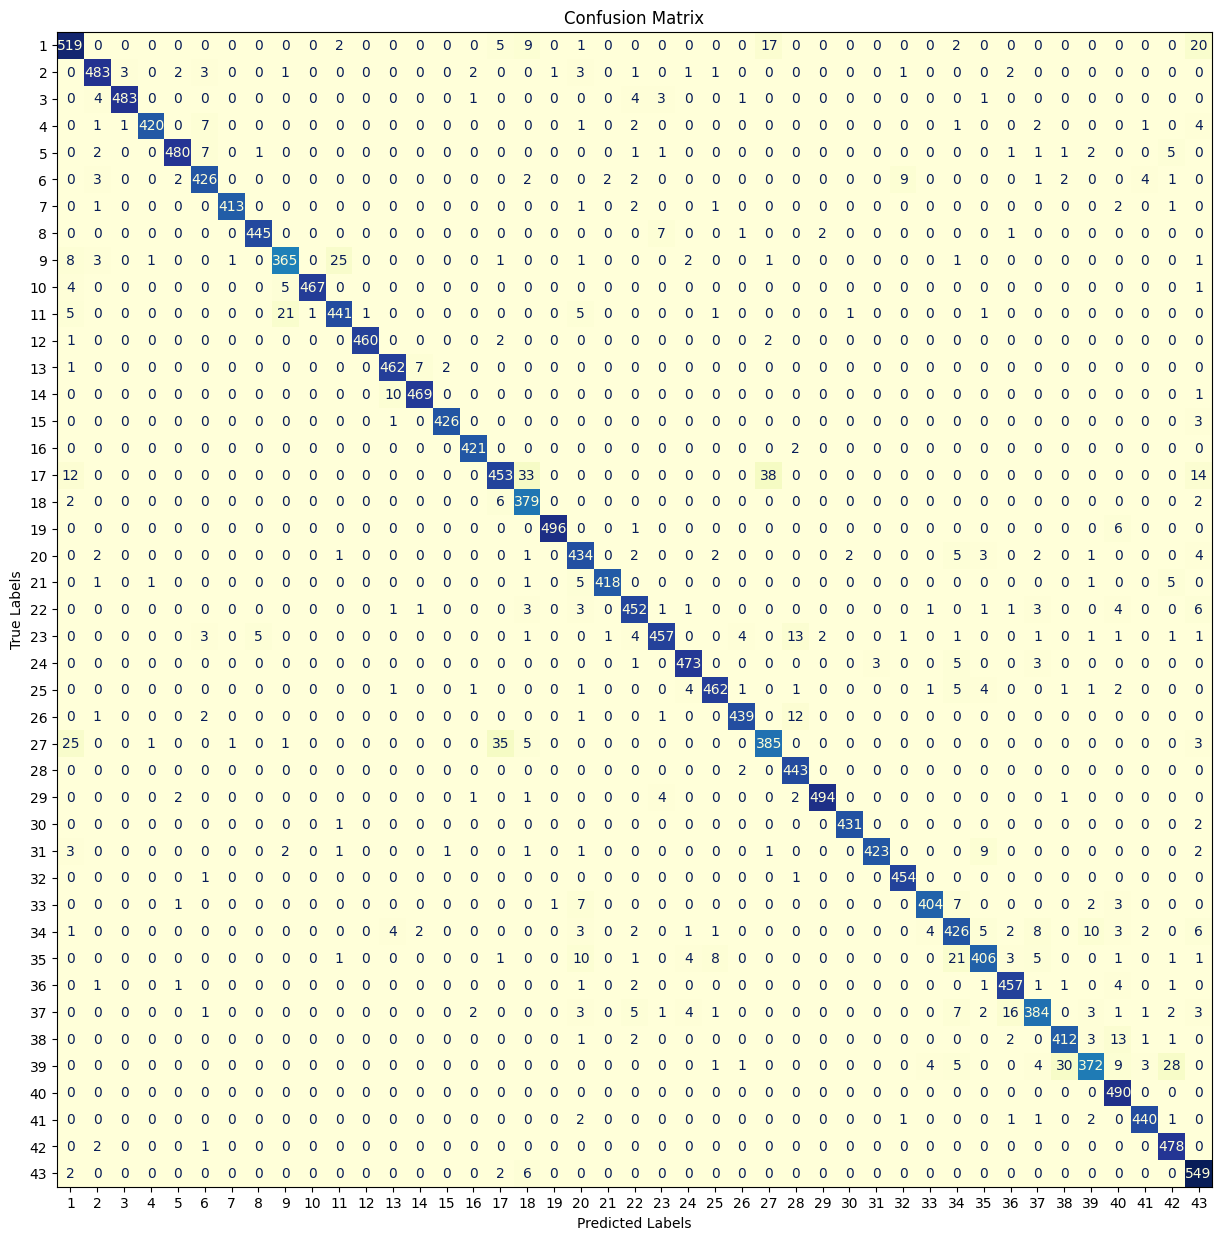

In [27]:
plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,44)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [18]:
train_datagen= ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False
                                  ,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)
val_datagen=ImageDataGenerator()

In [19]:
path_train=r'C:\Users\nabr9\OneDrive\Documents\диплом\data\data\train'

path_valid=r'C:\Users\nabr9\OneDrive\Documents\диплом\data\data\valid'

In [20]:
train= train_datagen.flow_from_directory(directory=path_train,batch_size=32,target_size=(200,200),
                                         color_mode='rgb',class_mode='categorical',seed=42)

valid=val_datagen.flow_from_directory(directory=path_valid,batch_size=32,target_size=(200,200),color_mode='rgb',class_mode='categorical')

Found 77873 images belonging to 43 classes.
Found 20101 images belonging to 43 classes.


In [21]:
model.save('model.h5')

In [22]:
base_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(200,200,3),classes=43)

In [25]:
#Model building
base_model_tf.trainable=False

pt=Input(shape=(200,200,3))
func=tf.cast(pt,tf.float32)
x=preprocess_input(func) #This function used to zero-center each color channel wrt Imagenet dataset
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dense(43,activation='softmax')(model_resnet)


model_main=Model(inputs=pt,outputs=model_resnet)
model_main.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
tf.cast_1 (TFOpLambda)       (None, 200, 200, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 200, 200, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 200, 200, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               2622

In [26]:
#CallBacks
es=EarlyStopping(monitor='val_accuracy',verbose=1,patience=7,mode='auto')
mc=ModelCheckpoint(filepath=r'C:\Users\nabr9\OneDrive\Documents\диплом',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=5,min_lr=0.001)


In [27]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [28]:
model_main.fit(train,validation_data=valid,epochs=30,steps_per_epoch=200,verbose=1,callbacks=[mc,es,lr])

Epoch 1/30
200/200 [==============================] - 68s 325ms/step - loss: 1.7656 - accuracy: 0.5291 - val_loss: 0.6497 - val_accuracy: 0.8082

Epoch 00001: val_accuracy improved from -inf to 0.80817, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
200/200 [==============================] - 64s 320ms/step - loss: 0.5499 - accuracy: 0.8309 - val_loss: 0.3930 - val_accuracy: 0.8792

Epoch 00002: val_accuracy improved from 0.80817 to 0.87916, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/30
200/200 [==============================] - 66s 329ms/step - loss: 0.4132 - accuracy: 0.8691 - val_loss: 0.3690 - val_accuracy: 0.8829

Epoch 00003: val_accuracy improved from 0.87916 to 0.88294, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/30
200/200 [==============================] - 65s 323ms/step - loss: 0.3424 - accuracy: 0.8895 - val_loss: 0.2864 - val_accuracy: 0.9073

Epoch 00004: val_accuracy improved from 0.88294 to 0.90727, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/30
200/200 [==============================] - 65s 327ms/step - loss: 0.2773 - accuracy: 0.9130 - val_loss: 0.3069 - val_accuracy: 0.8976

Epoch 00005: val_accuracy did not improve from 0.90727
Epoch 6/30
200/200 [==============================] - 65s 323ms/step - loss: 0.2737 - accuracy: 0.9087 - val_loss: 0.2259 - val_accuracy: 0.9211

Epoch 00006: val_accuracy improved from 0.90727 to 0.92115, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/30
200/200 [==============================] - 65s 322ms/step - loss: 0.2389 - accuracy: 0.9206 - val_loss: 0.2635 - val_accuracy: 0.9122

Epoch 00007: val_accuracy did not improve from 0.92115
Epoch 8/30
200/200 [==============================] - 65s 326ms/step - loss: 0.2256 - accuracy: 0.9253 - val_loss: 0.2270 - val_accuracy: 0.9245

Epoch 00008: val_accuracy improved from 0.92115 to 0.92453, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/30
200/200 [==============================] - 65s 323ms/step - loss: 0.2000 - accuracy: 0.9327 - val_loss: 0.2286 - val_accuracy: 0.9261

Epoch 00009: val_accuracy improved from 0.92453 to 0.92612, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/30
200/200 [==============================] - 65s 322ms/step - loss: 0.1991 - accuracy: 0.9359 - val_loss: 0.2049 - val_accuracy: 0.9301

Epoch 00010: val_accuracy improved from 0.92612 to 0.93010, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/30
200/200 [==============================] - 64s 319ms/step - loss: 0.1849 - accuracy: 0.9367 - val_loss: 0.2085 - val_accuracy: 0.9304

Epoch 00011: val_accuracy improved from 0.93010 to 0.93035, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/30
200/200 [==============================] - 68s 338ms/step - loss: 0.1945 - accuracy: 0.9347 - val_loss: 0.1839 - val_accuracy: 0.9390

Epoch 00012: val_accuracy improved from 0.93035 to 0.93896, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/30
200/200 [==============================] - 66s 329ms/step - loss: 0.1849 - accuracy: 0.9373 - val_loss: 0.2245 - val_accuracy: 0.9265

Epoch 00013: val_accuracy did not improve from 0.93896
Epoch 14/30
200/200 [==============================] - 66s 328ms/step - loss: 0.1852 - accuracy: 0.9364 - val_loss: 0.1855 - val_accuracy: 0.9396

Epoch 00014: val_accuracy improved from 0.93896 to 0.93960, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/30
200/200 [==============================] - 66s 329ms/step - loss: 0.1778 - accuracy: 0.9373 - val_loss: 0.1498 - val_accuracy: 0.9482

Epoch 00015: val_accuracy improved from 0.93960 to 0.94821, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/30
200/200 [==============================] - 69s 345ms/step - loss: 0.1560 - accuracy: 0.9458 - val_loss: 0.1614 - val_accuracy: 0.9442

Epoch 00016: val_accuracy did not improve from 0.94821
Epoch 17/30
200/200 [==============================] - 67s 336ms/step - loss: 0.1526 - accuracy: 0.9491 - val_loss: 0.1543 - val_accuracy: 0.9484

Epoch 00017: val_accuracy improved from 0.94821 to 0.94836, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/30
200/200 [==============================] - 65s 326ms/step - loss: 0.1770 - accuracy: 0.9423 - val_loss: 0.1536 - val_accuracy: 0.9481

Epoch 00018: val_accuracy did not improve from 0.94836
Epoch 19/30
200/200 [==============================] - 65s 328ms/step - loss: 0.1595 - accuracy: 0.9464 - val_loss: 0.1392 - val_accuracy: 0.9524

Epoch 00019: val_accuracy improved from 0.94836 to 0.95239, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/30
200/200 [==============================] - 65s 327ms/step - loss: 0.1561 - accuracy: 0.9456 - val_loss: 0.1436 - val_accuracy: 0.9514

Epoch 00020: val_accuracy did not improve from 0.95239
Epoch 21/30
200/200 [==============================] - 65s 328ms/step - loss: 0.1596 - accuracy: 0.9464 - val_loss: 0.1374 - val_accuracy: 0.9529

Epoch 00021: val_accuracy improved from 0.95239 to 0.95294, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/30
200/200 [==============================] - 66s 328ms/step - loss: 0.1620 - accuracy: 0.9427 - val_loss: 0.1353 - val_accuracy: 0.9548

Epoch 00022: val_accuracy improved from 0.95294 to 0.95483, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 23/30
200/200 [==============================] - 67s 333ms/step - loss: 0.1569 - accuracy: 0.9495 - val_loss: 0.1390 - val_accuracy: 0.9537

Epoch 00023: val_accuracy did not improve from 0.95483
Epoch 24/30
200/200 [==============================] - 66s 329ms/step - loss: 0.1367 - accuracy: 0.9542 - val_loss: 0.1496 - val_accuracy: 0.9518

Epoch 00024: val_accuracy did not improve from 0.95483
Epoch 25/30
200/200 [==============================] - 66s 328ms/step - loss: 0.1445 - accuracy: 0.9514 - val_loss: 0.1356 - val_accuracy: 0.9550

Epoch 00025: val_accuracy improved from 0.95483 to 0.95498, saving model to C:\Users\nabr9\OneDrive\Documents\диплом
INFO:tensorflow:Assets written to: C:\Users\nabr9\OneDrive\Documents\диплом\assets


C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/30
200/200 [==============================] - 65s 325ms/step - loss: 0.1276 - accuracy: 0.9558 - val_loss: 0.1764 - val_accuracy: 0.9441

Epoch 00026: val_accuracy did not improve from 0.95498
Epoch 27/30
200/200 [==============================] - 65s 325ms/step - loss: 0.1249 - accuracy: 0.9569 - val_loss: 0.1356 - val_accuracy: 0.9548

Epoch 00027: val_accuracy did not improve from 0.95498
Epoch 28/30
200/200 [==============================] - 65s 324ms/step - loss: 0.1241 - accuracy: 0.9569 - val_loss: 0.1321 - val_accuracy: 0.9550

Epoch 00028: val_accuracy did not improve from 0.95498
Epoch 29/30
200/200 [==============================] - 65s 325ms/step - loss: 0.1339 - accuracy: 0.9538 - val_loss: 0.1372 - val_accuracy: 0.9527

Epoch 00029: val_accuracy did not improve from 0.95498
Epoch 30/30
200/200 [==============================] - 65s 324ms/step - loss: 0.1320 - accuracy: 0.9570 - val_loss: 0.1293 - val_accuracy: 0.9581

Epoch 00030: val_accuracy improved from 0.954

C:\Users\nabr9\anaconda3\envs\cudakeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Text(0.5, 1.0, 'Train and Validation Loss Resnet50')

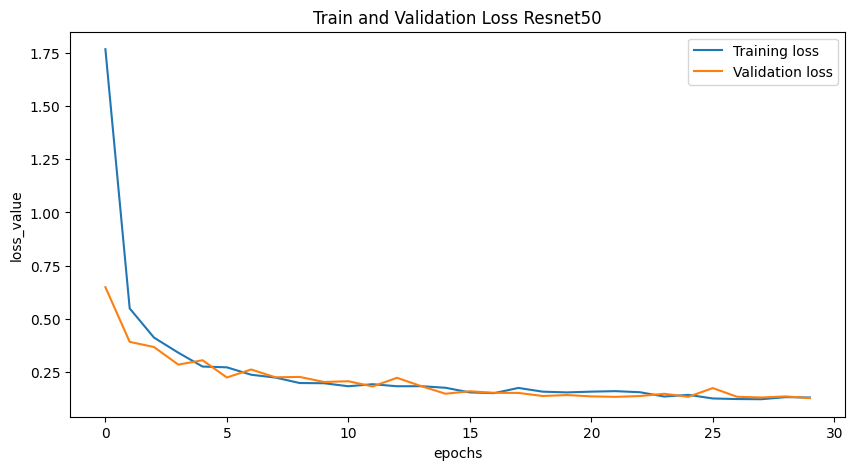

In [32]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],label='Training loss')
plt.plot(model_main.history.history['val_loss'],label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss_value")
plt.legend()
plt.title("Train and Validation Loss Resnet50")

Text(0.5, 1.0, 'Train and Validation accuracy Resnet50')

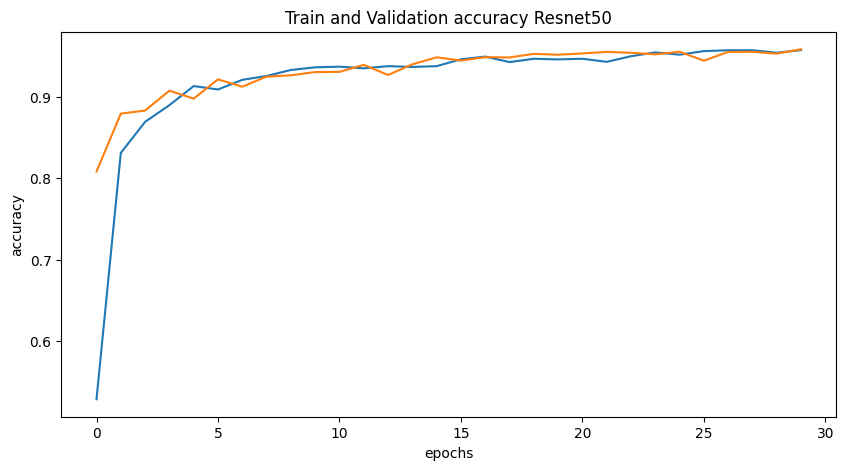

In [33]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Train and Validation accuracy Resnet50")

In [ ]:
# воспользоваться моделью можно по ссылке
# https://drive.google.com/drive/folders/1IjbQppBuFtnCd6mgimOgWC-GUUR6Rb-L?usp=share_link